In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Transform:
    # Requirements:
        # import os
        # import pickle
        # import pandas as pd
        # import matplotlib.pyplot as plt
    
    def __init__(self, keyword):
        self.keyword = keyword
        
    def aggFromPickles(self, inputPath):
        df = pd.DataFrame()
        for root, _, files in os.walk(inputPath):
            for file in files:
                if file.endswith(".pkl"):
                    year = file.split('-')[0]
                    month = file.split('-')[1]
                    with open(os.path.join(root, file), 'rb') as f:
                        df_temp = pickle.load(f)
                df_temp = pd.DataFrame(df_temp.iloc[:, 1:].mean()).T
                df_temp['Year-month'] = year + '-' + month
                df = df.append(df_temp)

        df.columns = df.columns.str.replace('"', '')
        df = df.reset_index(drop=True)
        self.df = df
    
    def lineplot(self):
        plt.figure(figsize=(9,7))
        for i in range(len(self.df.columns)-1):
            plt.plot(self.df.iloc[:, i])
        plt.xticks(np.arange(0, 171, 12), np.arange(2006, 2021), rotation=60)
        plt.xlabel('Year')
        plt.ylabel('Global mean')
        plt.legend()
        plt.show()
    
    def toPickle(self, outputPath):
        fileName = 'transform' + '-' + self.keyword
        pathName = str(outputPath) + '/' + fileName + '.pkl'
        with open(pathName, 'wb') as f:
            pickle.dump(self.df, f)

In [3]:
t = Transform('camera')

camera


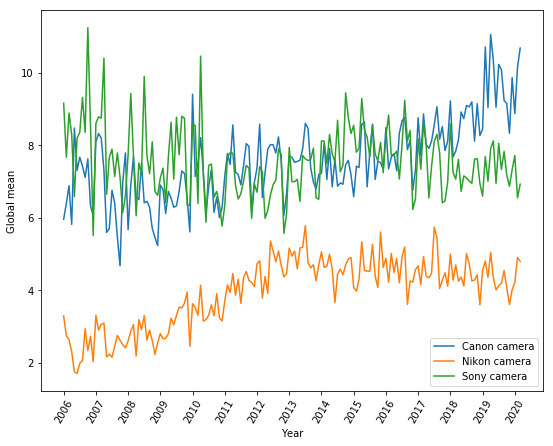

In [4]:
print(t.keyword)
t.aggFromPickles('../data/raw/camera')
t.plot()

In [6]:
t.toPickle('pickleTest')

In [7]:
with open('pickleTest/transform-camera.pkl', 'rb') as f:
    myobject = pickle.load(f)

In [8]:
myobject

,Canon camera,Nikon camera,Sony camera,Year-month
0,5.956,3.288,9.156,2006-01
1,6.392,2.740,7.668,2006-02
2,6.880,2.632,8.888,2006-03
3,5.816,2.296,8.288,2006-04
4,8.472,1.744,6.584,2006-05
...,...,...,...,...
166,8.328,3.604,6.868,2019-11
167,9.864,4.012,7.324,2019-12
168,8.872,4.216,7.712,2020-01
169,10.152,4.900,6.548,2020-02


In [ ]:
df = pd.DataFrame()
for root, dirs, files in os.walk("../data/raw/camera"):
    for file in files:
        if file.endswith(".pkl"):
            year = file.split('-')[0]
            month = file.split('-')[1]
            with open(os.path.join(root, file), 'rb') as f:
                df_temp = pickle.load(f)
        df_temp = pd.DataFrame(df_temp.iloc[:, 1:].mean()).T
        df_temp['Year-month'] = year + '-' + month
        df = df.append(df_temp)

df.columns = df.columns.str.replace('"', '')
df = df.reset_index(drop=True)

In [ ]:
df

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(df.iloc[:, 0])
plt.xticks(np.arange(0, 171, 12), np.arange(2006, 2021), rotation=60)
plt.show()

In [ ]:
with open('data/agg-camera.pkl', 'wb') as f:
            pickle.dump(self.trend, f)

In [ ]:
#a = pd.DataFrame()
a = a.append(edit)
a

In [ ]:
os.getcwd()

In [ ]:
edit = pd.DataFrame(testObject.iloc[:, 1:].mean()).T
edit.columns = edit.columns.str.replace('"', '')
edit['Year-month'] = 'test'
#edit.columns = ['Year-month', '"Canon" "camera"', '"Nikon" "camera"', '"Sony" "camera"']
#edit_copy = edit.copy()
#testObject.append(edit_copy)
#testObject
edit

In [ ]:
test2 = pd.DataFrame({'Canon camera': [1], 
                      'Nikon camera': [2], 
                      'Sony camera': [3], 
                      'Year-month': ['2020-04']}
                    )
test2

In [ ]:
edit = edit.append(test2)
edit

In [ ]:
'"Nikon" "camera"'.replace('"', '')

In [ ]:
testObject.loc[testObject['"Canon" "camera"']==100]

In [ ]:
testObject